# Residential Heat Pump Case Study 4:  Cold-Climate Heat Pump in a Century Townhome
Created: 01/2022  
Erik Janssen, Analyst Sustainable Technologies Evaluation Program (STEP)  
Toronto and Region Conservation Authority (TRCA)  

## 1 Introduction
This Jupyter Notebook was used to analyze the changes in utility consumption pre- and post-retrofit for the air-source heat pump (ASHP) system analyzed in the accompanying case study. The basic process of the analysis is:

1) Import utility data pre- and post-retrofit.  

2) Create a linear regression model of the pre-retrofit data as a function of heating degree days (HDDs) - and CDDs if necessary. 

3) Determine savings by comparing baseline against actual post-retrofit utility data. 

4) Ensure that the utility impacts attributed to the ASHP system are reasonable by calculating the average COP from the gas savings and electricity increase. Compare the calculated average COP against manufacturer data (i.e. an expected COP). The COP calculated from the utility data should be near that expected based on the manufacturer data. Note COP was not explicitly monitoried, this is just to ensure that it is reasonable to attribute a certain gas savings to the ASHP based on how much electricity it consumed.

5) Estimate utility rates and calculate other parameters like cost and carbon savings. 

6) Consider utility implications for carbon pricing schedule looking out to 2030 and beyond.

7) Perform a full net present value (NPV) business case analysis.

## 2 Libraries

In [235]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.dates as mdates

# Set some basic parameters for plotting and visualizing data
font = {'size'   : 16}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)
MonthFmt = mdates.DateFormatter('%m/%Y')

## 3 Import Data

### 3.1 Import Weather Data

In [236]:
# Import hourly weather data file for Toronto and calculate HDDs and CDDs
# Assumed building balance points to create the best linear relationships - in this case it was lower than usual
toronto_weather = pd.read_csv("weatherstats_toronto_hourly_10yr.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(12 - x)*(1/24) if (x < 12) else 0 for x in toronto_weather.temperature] 
toronto_weather['CDDs'] = [(x-28)*(1/24) if (x > 28) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,temperature,HDDs,CDDs
date_time_local,,,
2021-11-30 12:00:00,0.6,0.475000,0.0
2021-11-30 11:00:00,-0.2,0.508333,0.0
2021-11-30 10:00:00,-0.7,0.529167,0.0
2021-11-30 09:00:00,-1.4,0.558333,0.0
2021-11-30 08:00:00,-1.9,0.579167,0.0


In [237]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>=start_date)&(toronto_weather.index<end_date)]
    total_HDDs = temp_df.HDDs.sum()
    total_CDDs = temp_df.CDDs.sum()
    return {'HDDs':total_HDDs,
            'CDDs':total_CDDs}

### 3.2 Import Gas Data

In [238]:
# Import data
gas_data = pd.read_csv('Gas_Consumption.csv',parse_dates = ['To','From'])
gas_data.head(12)

,From,To,m3
0,2019-12-28,2020-02-27,660
1,2020-02-27,2020-04-27,397
2,2020-04-27,2020-06-26,91
3,2020-06-26,2020-08-28,74
4,2020-08-28,2020-10-27,24
5,2020-10-27,2020-12-30,81
6,2020-12-30,2021-02-26,38
7,2021-02-26,2021-04-26,37
8,2021-04-26,2021-06-26,17
9,2021-06-26,2021-08-26,35


Gas data was obtained from the actual utility bills that were shared by the homeowner. "Actual" meter readings are taken by Enbridge every other month and these meter readings are provided on the utility bill. Gas consumption was then determined on a bi-monthly basis by determing the difference between the current "Actual" reading and the "Actual" reading from 2-months prior. This approach avoids confusion around the "Estimated" gas consumption data Enbridge uses for those months when "Actual" readings were not taken. 

Text(0, 0.5, 'Gas Consumption [m$^{3}$]')

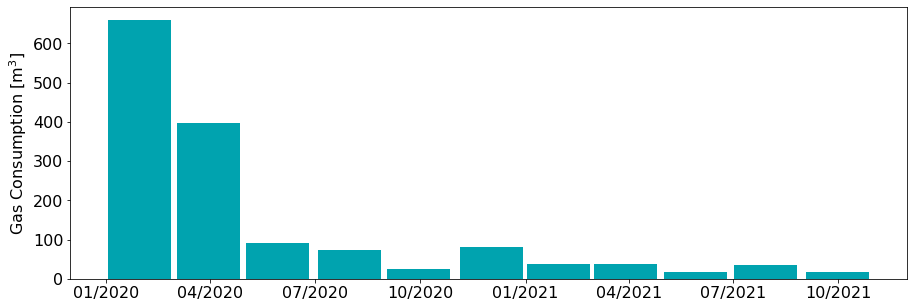

In [239]:
# Quick Visualization
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(gas_data.To,gas_data.m3, width = -55, align = 'edge',color = step_blue)
ax.xaxis.set_major_formatter(MonthFmt)
ax.set_ylabel('Gas Consumption [m$^{3}$]')

It's clear the gas load has almost entirely been eliminated.

Now add HDDs and CDDs to the gas dataframe.

In [240]:
# Add HDDs to gas post-retrofit dataframe
gas_data['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_data.From,gas_data.To)]
gas_data['CDDs'] = [HDD_total(x,y)['CDDs'] for x,y in zip(gas_data.From,gas_data.To)]
gas_data

,From,To,m3,HDDs,CDDs
0,2019-12-28,2020-02-27,660,820.512500,0.000000
1,2020-02-27,2020-04-27,397,507.800000,0.000000
2,2020-04-27,2020-06-26,91,96.433333,3.362500
3,2020-06-26,2020-08-28,74,0.012500,24.095833
4,2020-08-28,2020-10-27,24,75.004167,0.029167
5,2020-10-27,2020-12-30,81,573.908333,0.000000
6,2020-12-30,2021-02-26,38,915.500000,0.000000
7,2021-02-26,2021-04-26,37,436.008333,0.000000
8,2021-04-26,2021-06-26,17,77.875000,5.291667
9,2021-06-26,2021-08-26,35,0.050000,10.891667


Define pre- and post-retrofit dataframes for the gas data. Note the install took place in early November 2020. The next actual gas reading was taken 12/30/2020 - so this is when the post-retrofit dataframe must start. It finished 10 months later on 10/28/2021. The pre-retrofit period goes from 12/28/2019 to 10/27/2020. Both periods are 10-months.

In [241]:
pre_gas_data = gas_data.loc[(gas_data.index < 5)].copy()
post_gas_data = gas_data.loc[(gas_data.index > 5)].copy()

In [242]:
# Have a look
pre_gas_data

,From,To,m3,HDDs,CDDs
0,2019-12-28,2020-02-27,660,820.512500,0.000000
1,2020-02-27,2020-04-27,397,507.800000,0.000000
2,2020-04-27,2020-06-26,91,96.433333,3.362500
3,2020-06-26,2020-08-28,74,0.012500,24.095833
4,2020-08-28,2020-10-27,24,75.004167,0.029167


In [243]:
# Have a look
post_gas_data

,From,To,m3,HDDs,CDDs
6,2020-12-30,2021-02-26,38,915.500000,0.000000
7,2021-02-26,2021-04-26,37,436.008333,0.000000
8,2021-04-26,2021-06-26,17,77.875000,5.291667
9,2021-06-26,2021-08-26,35,0.050000,10.891667
10,2021-08-26,2021-10-28,17,37.770833,1.370833


Visualize gas consumption vs. HDDs.

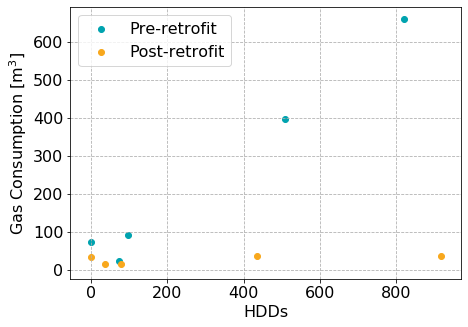

In [244]:
plt.figure(figsize=(7,5))
plt.scatter(pre_gas_data.HDDs,pre_gas_data.m3, color = step_blue, label = 'Pre-retrofit')
plt.scatter(post_gas_data.HDDs,post_gas_data.m3, color = step_gold, label = 'Post-retrofit')
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.xlabel('HDDs')
plt.grid(ls='--')
plt.legend()

As expected, pre-retrofit data is very linear. This will make it easy to model a baseline.

### 3.3 Import Electricity Data

In [245]:
elec_data = pd.read_csv('Elec_data.csv',parse_dates = ['To','From'])
elec_data.head(24)

,From,To,kWh_PreAdj,kWh,Factor
0,2021-11-10,2021-12-09,1203,1238.4885,1.029500
1,2021-10-12,2021-11-10,581,598.1395,1.029500
2,2021-09-10,2021-10-12,389,400.4755,1.029500
3,2021-08-11,2021-09-10,535,550.7825,1.029500
4,2021-07-12,2021-08-11,442,455.0390,1.029500
5,2021-06-12,2021-07-12,394,405.6230,1.029500
6,2021-05-11,2021-06-12,318,327.3810,1.029500
7,2021-04-12,2021-05-11,550,566.2250,1.029500
8,2021-03-09,2021-04-12,808,831.8360,1.029500
9,2021-02-08,2021-03-09,1858,1912.8110,1.029500


In [246]:
# Add HDDs and CDDs
elec_data['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec_data.From,elec_data.To)]
elec_data['CDDs'] = [HDD_total(x,y)['CDDs'] for x,y in zip(elec_data.From,elec_data.To)]
elec_data

,From,To,kWh_PreAdj,kWh,Factor,HDDs,CDDs
0,2021-11-10,2021-12-09,1203,1238.4885,1.029500,179.133333,0.000000
1,2021-10-12,2021-11-10,581,598.1395,1.029500,98.554167,0.000000
2,2021-09-10,2021-10-12,389,400.4755,1.029500,4.316667,0.000000
3,2021-08-11,2021-09-10,535,550.7825,1.029500,0.000000,6.620833
4,2021-07-12,2021-08-11,442,455.0390,1.029500,0.050000,1.912500
5,2021-06-12,2021-07-12,394,405.6230,1.029500,0.912500,4.120833
6,2021-05-11,2021-06-12,318,327.3810,1.029500,23.450000,4.900000
7,2021-04-12,2021-05-11,550,566.2250,1.029500,127.887500,0.000000
8,2021-03-09,2021-04-12,808,831.8360,1.029500,209.316667,0.000000
9,2021-02-08,2021-03-09,1858,1912.8110,1.029500,478.245833,0.000000


Text(0, 0.5, 'Electricity Consumption [kWh]')

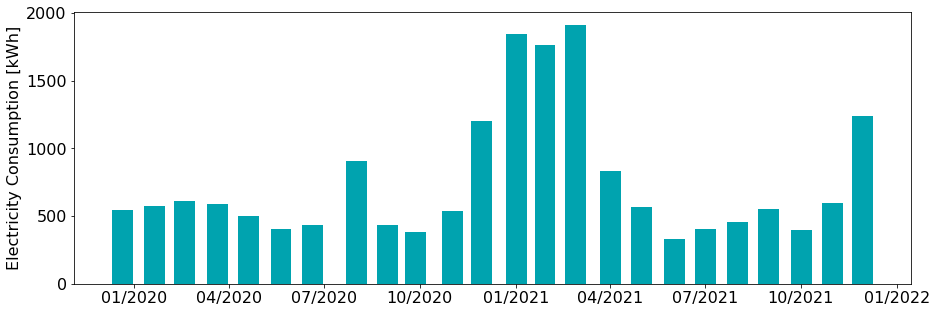

In [247]:
# Quick time-series visualization
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(elec_data.To,elec_data.kWh, width = -20, align = 'edge',color = step_blue)
ax.xaxis.set_major_formatter(MonthFmt)
ax.set_ylabel('Electricity Consumption [kWh]')

Note the electricity intervals are not constant. Not an issue since we are doing a modelled baseline.

Can see drastically increased electricity consumption post-retrofit, as expected.

Define pre- and post- dataframes. Looking for comparable 10-month periods that are as closely aligned with gas data as possible. Pre-starts at 2020-01-01 and ends at 2020-11-11. So it has 10-months plus 10 days. This is not a problem since the pre-retrofit data will inform a model of baseline consumption and will not be used in a direct comparison.

Post-retrofit electricity data goes from 1/13/2021 to 11/10/2020 - so 10 months minus 3 days. The length of the post-retrofit gas and electricity data is then very close but the time periods are offset by approximately 10 days. The post-retrofit electricity data includes less of January in exchange for more of November.

This will be corrected for in a subsequent step.

In [248]:
pre_elec_data = elec_data.loc[(elec_data.index < 23) & (elec_data.index > 12)].copy()
pre_elec_data

,From,To,kWh_PreAdj,kWh,Factor,HDDs,CDDs
13,2020-10-07,2020-11-11,521,536.3695,1.029500,121.066667,0.000000
14,2020-09-10,2020-10-07,371,381.9445,1.029500,22.900000,0.000000
15,2020-08-11,2020-09-10,420,432.3900,1.029500,0.216667,2.704167
16,2020-06-30,2020-08-11,882,908.0190,1.029500,0.000000,20.158333
17,2020-05-31,2020-06-30,424,436.5060,1.029495,4.666667,3.912500
18,2020-04-30,2020-05-31,390,401.5030,1.029495,84.225000,0.712500
19,2020-03-31,2020-04-30,490,504.4530,1.029496,190.225000,0.000000
20,2020-02-29,2020-03-31,570,586.8120,1.029495,290.575000,0.000000
21,2020-01-31,2020-02-29,589,611.1400,1.037589,418.900000,0.000000
22,2019-12-31,2020-01-31,557,577.9432,1.037600,407.533333,0.000000


In [249]:
post_elec_data = elec_data.loc[(elec_data.index < 11) & (elec_data.index > 0)].copy()
post_elec_data

,From,To,kWh_PreAdj,kWh,Factor,HDDs,CDDs
1,2021-10-12,2021-11-10,581,598.1395,1.0295,98.554167,0.000000
2,2021-09-10,2021-10-12,389,400.4755,1.0295,4.316667,0.000000
3,2021-08-11,2021-09-10,535,550.7825,1.0295,0.000000,6.620833
4,2021-07-12,2021-08-11,442,455.0390,1.0295,0.050000,1.912500
5,2021-06-12,2021-07-12,394,405.6230,1.0295,0.912500,4.120833
6,2021-05-11,2021-06-12,318,327.3810,1.0295,23.450000,4.900000
7,2021-04-12,2021-05-11,550,566.2250,1.0295,127.887500,0.000000
8,2021-03-09,2021-04-12,808,831.8360,1.0295,209.316667,0.000000
9,2021-02-08,2021-03-09,1858,1912.8110,1.0295,478.245833,0.000000
10,2021-01-12,2021-02-08,1714,1764.5630,1.0295,420.700000,0.000000


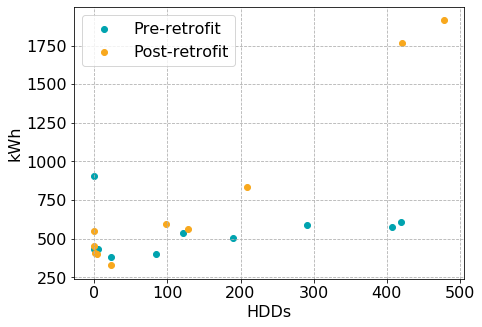

In [250]:
# Visualize vs. HDDs
plt.figure(figsize=(7,5))
plt.scatter(pre_elec_data.HDDs,pre_elec_data.kWh, color = step_blue, label = 'Pre-retrofit')
plt.scatter(post_elec_data.HDDs,post_elec_data.kWh, color = step_gold, label = 'Post-retrofit')
plt.ylabel('kWh')
plt.xlabel('HDDs')
plt.grid(ls='--')
plt.legend()

You can see the pre-retrofit data has a small dependence on HDDs. This is because there was already a Mitsubishi Mr.Slim heat pump on the upper floor because the furnace ductwork did not reach there. You can also see that pre-retrofit there was an electricit spike during summer (when HDDs was 0). It's useful to look at the relationship with CDDs as well.

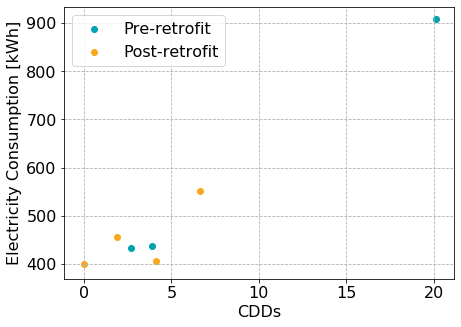

In [251]:
# Visualize vs. CDDs
plt.figure(figsize=(7,5))
plt.scatter(pre_elec_data.loc[pre_elec_data.HDDs < 10].CDDs,
            pre_elec_data.loc[pre_elec_data.HDDs < 10].kWh, 
            color = step_blue,
            label = 'Pre-retrofit')
plt.scatter(post_elec_data.loc[post_elec_data.HDDs < 10].CDDs,
            post_elec_data.loc[post_elec_data.HDDs < 10].kWh, 
            color = step_gold,
            label = 'Post-retrofit')
plt.ylabel('Electricity Consumption [kWh]')
plt.xlabel('CDDs')
plt.grid(ls='--')
plt.legend()

The pre- and post retrofit cooling data show a very similar trend and there is not enough data to distinguish one from the other. There should be a cooling mode savings. The ASHP has a high SEER ratings. There just is not enough data to actually see it. One issue is that the data points don't cover constant periods of time. The cooling spike where consumption is higher than 800 kWh actually covers 40 days rather than month - so some of the extra consumption is just due to the fact that it covers a longer duration. There is nothing I can do without higher resolution data which I don't have.

Since I can't distinguish between the pre- and post-retrofit cooling energy consumption, I will just assume there was indeed no significant change when I go calculate the savings. This is a conservative estimate in favour of the conventional system. 

## 4 Define Linear Regression Models of Baseline Utility Consumption and Calculate Total Utility Consumption

### 4.1 Baseline Models

coefficient of determination: 0.786419813341645
intercept: 401.6747009969727
slope: [0.51350101]


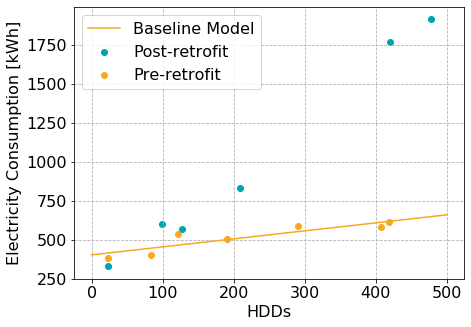

In [252]:
# Calculate regression line for baseline electricity data
x = np.array(pre_elec_data.loc[pre_elec_data.HDDs > 10].HDDs).reshape((-1, 1))
y = np.array(pre_elec_data.loc[pre_elec_data.HDDs > 10].kWh)
base_model_elec = LinearRegression()
base_model_elec.fit(x, y)
base_model_elec_r_sq = base_model_elec.score(x, y)
print('coefficient of determination:', base_model_elec_r_sq)
print('intercept:', base_model_elec.intercept_)
print('slope:', base_model_elec.coef_)

# Define baseline elec function
def base_elec_model(HDDs):
    kWh = base_model_elec.coef_[0]*HDDs + base_model_elec.intercept_
    return kWh

# Visualize
plt.figure(figsize = (7,5))
plt.grid(ls='--')
x = [0,500]
y = [base_elec_model(a) for a in x]
plt.scatter(post_elec_data.loc[post_elec_data.HDDs > 10].HDDs,post_elec_data.loc[post_elec_data.HDDs > 10].kWh, color = step_blue, label = 'Post-retrofit')
plt.scatter(pre_elec_data.loc[pre_elec_data.HDDs > 10].HDDs,pre_elec_data.loc[pre_elec_data.HDDs > 10].kWh, color = step_gold, label = 'Pre-retrofit')
plt.plot(x,y, color = step_gold, label = 'Baseline Model')
plt.xlabel('HDDs')
plt.ylabel('Electricity Consumption [kWh]')
plt.legend()

The baseline electricity model has a reasonably good coefficient of determination (0.76), meaning it is a good representation of baseline electricity consumption.

Now do gas.

coefficient of determination: 0.9796182014384591
intercept: 19.49384053184994
slope: [0.76580845]


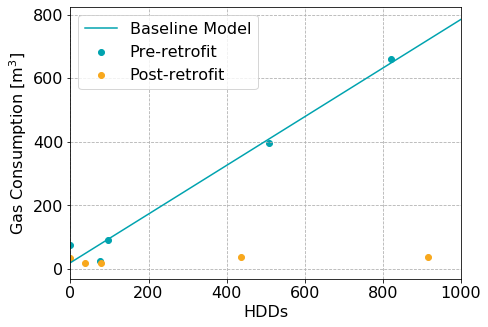

In [253]:
# Calculate regression line for baseline data
x = np.array(pre_gas_data.HDDs).reshape((-1, 1))
y = np.array(pre_gas_data.m3)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination:', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

# Function for baseline model
def baseline_gas(HDDs):
    m3 = base_model_gas.coef_[0]*HDDs + base_model_gas.intercept_
    return m3

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,1000]
y = [baseline_gas(a) for a in x]
plt.figure(figsize = (7,5))
plt.scatter(pre_gas_data.HDDs,pre_gas_data.m3, color = step_blue, label = 'Pre-retrofit')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
plt.xlim(0,1000)
plt.xlabel('HDDs')
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.grid(ls='--')
plt.scatter(post_gas_data.HDDs,post_gas_data.m3, color = step_gold, label = 'Post-retrofit')
plt.legend(loc = 2)

Baseline gas model is a very good representation of actual consumption.

### 4.2 Add Baseline Model to Dataframes and Calculate Totals

In [254]:
# Add modelled baseline to post-retrofit gas data consumption dataframe
# Recall - baseline is what would have happened had there been no heat pump retrofit
post_gas_data['modelled_m3'] = [baseline_gas(x) for x in post_gas_data.HDDs]
post_gas_data

,From,To,m3,HDDs,CDDs,modelled_m3
6,2020-12-30,2021-02-26,38,915.500000,0.000000,720.591478
7,2021-02-26,2021-04-26,37,436.008333,0.000000,353.392707
8,2021-04-26,2021-06-26,17,77.875000,5.291667,79.131174
9,2021-06-26,2021-08-26,35,0.050000,10.891667,19.532131
10,2021-08-26,2021-10-28,17,37.770833,1.370833,48.419064


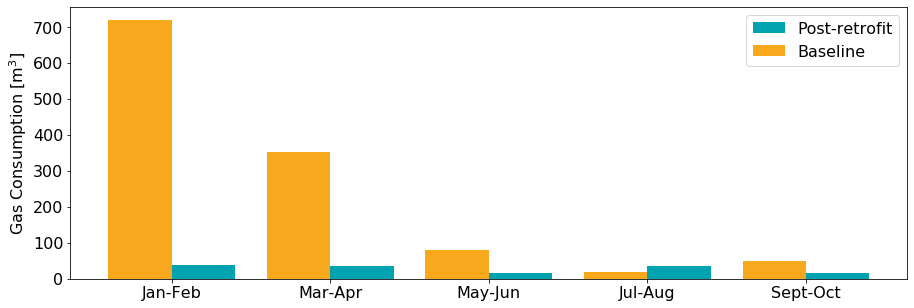

In [255]:
# Visualize
labels = [0,'Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sept-Oct'] # Don't know why I need the 0...
pos = [0,1,2,3,4]
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(pos,post_gas_data.m3, width = 0.4, align = 'edge', color = step_blue, label = 'Post-retrofit')
ax.bar(pos,post_gas_data.modelled_m3, width = -0.4, align = 'edge', color = step_gold, label = 'Baseline')
ax.set_ylabel('Gas Consumption [m$^{3}$]')
ax.set_xticklabels(labels)
plt.legend()

Now calculate totals for actual and modelled baseline gas consumption.

In [256]:
# Actual post-retrofit gas consumption
post_gas_total = post_gas_data.m3.sum()
post_gas_total

144

In [257]:
# Modelled baseline gas consumption
post_gas_base_total = post_gas_data.modelled_m3.sum()
post_gas_base_total

1221.0665531753066

In [258]:
# Gas savings
gas_savings = post_gas_base_total - post_gas_total
gas_savings

1077.0665531753066

In [259]:
# Percentage gas savings
1-post_gas_total/post_gas_base_total

0.8820703100698835

Calculate totals for actual and modelled baseline electricity consumption.

In [260]:
# Add modelled baseline to post-retrofit elec data consumption dataframe
# Recall - baseline is what would have happened had there been no heat pump retrofit
post_elec_data['modelled_kWh'] = [base_elec_model(x) for x in post_elec_data.HDDs]
post_elec_data

,From,To,kWh_PreAdj,kWh,Factor,HDDs,CDDs,modelled_kWh
1,2021-10-12,2021-11-10,581,598.1395,1.0295,98.554167,0.000000,452.282365
2,2021-09-10,2021-10-12,389,400.4755,1.0295,4.316667,0.000000,403.891314
3,2021-08-11,2021-09-10,535,550.7825,1.0295,0.000000,6.620833,401.674701
4,2021-07-12,2021-08-11,442,455.0390,1.0295,0.050000,1.912500,401.700376
5,2021-06-12,2021-07-12,394,405.6230,1.0295,0.912500,4.120833,402.143271
6,2021-05-11,2021-06-12,318,327.3810,1.0295,23.450000,4.900000,413.716300
7,2021-04-12,2021-05-11,550,566.2250,1.0295,127.887500,0.000000,467.345062
8,2021-03-09,2021-04-12,808,831.8360,1.0295,209.316667,0.000000,509.159021
9,2021-02-08,2021-03-09,1858,1912.8110,1.0295,478.245833,0.000000,647.254421
10,2021-01-12,2021-02-08,1714,1764.5630,1.0295,420.700000,0.000000,617.704577


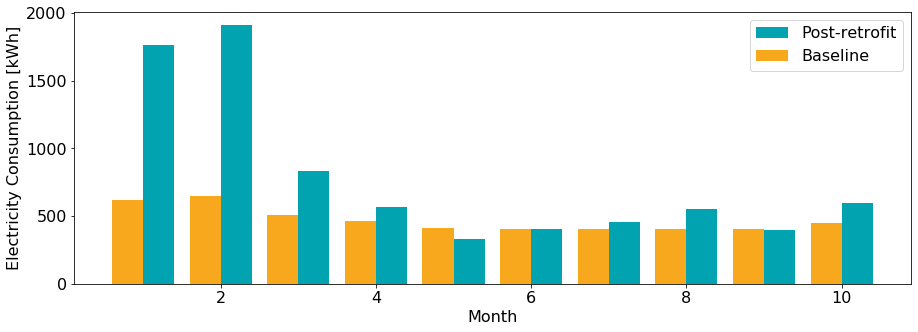

In [261]:
# Visualize
def reverse_list(input): #it's in the wronf order for plotting
    output = input[::-1] 
    return output 

pos = [1,2,3,4,5,6,7,8,9,10]
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(pos,reverse_list(post_elec_data.kWh.to_list()), width = 0.4, align = 'edge', color = step_blue, label = 'Post-retrofit')
ax.bar(pos,reverse_list(post_elec_data.modelled_kWh.to_list()), width = -0.4, align = 'edge', color = step_gold, label = 'Baseline')
ax.set_ylabel('Electricity Consumption [kWh]')
ax.set_xlabel('Month') #It doesn't align perfectly by month but it's simpler to plot this way
plt.legend()

In [262]:
post_elec_total = post_elec_data.kWh.sum()
post_elec_total

7812.8755

In [263]:
post_elec_baseline = post_elec_data.modelled_kWh.sum()
post_elec_baseline

4716.871407914829

In [264]:
elec_increase = post_elec_total - post_elec_baseline
elec_increase

3096.0040920851707

### 4.3 HDD Correction and Recalculate Savings

Note that the post-retrofit electricity consumption dataframe contains 301 days, while the post-retrofit gas consumption dataframe contains 302 days, so both cover the same amount of time. However, they are offset by approximately 2 weeks. Can look at the impact of that offset by looking at the total HDDs for the post-retrofit electricity dataframe and the post-retrofit gas dataframe.

In [265]:
# HDDs in gas dataframe
post_gas_data.HDDs.sum()

1467.2041666666664

In [266]:
# HDDs for post-retrofit gas data - Check
start = datetime.datetime.strptime("2020-12-30","%Y-%m-%d")
stop = datetime.datetime.strptime("2021-10-28","%Y-%m-%d")
HDDs_gas = HDD_total(start,stop)['HDDs'] 
HDDs_gas

1467.2041666666667

In [267]:
# HDDs in elec data frame
post_elec_data.HDDs.sum()

1363.4333333333334

In [268]:
# HDDs for post-retrofit elec data - Check
start = datetime.datetime.strptime("2021-01-12","%Y-%m-%d")
stop = datetime.datetime.strptime("2021-11-10","%Y-%m-%d")
HDDs_elec = HDD_total(start,stop)['HDDs'] 
HDDs_elec

1363.4333333333332

In [269]:
# The percentage difference in HDDs is significant
# The HDDs for electricity sata is lower - this makes the ASHP look better than it actually was
(post_gas_data.HDDs.sum()/post_elec_data.HDDs.sum()-1)*(100)

7.610994303596286

In [270]:
# Difference in HDDs
HDD_diff = post_gas_data.HDDs.sum()-post_elec_data.HDDs.sum()
HDD_diff

103.77083333333303

The modelled baseline gas consumption needs to be correct such that it that it is representative of a similar amount of HDDs as the electricity data. To do that, I can just take the slope of the baseline gas model multiply it be the HDD difference and use that as a correction term.

In [271]:
# Calculate correction term for baseline gas model
m3_HDD_corr = HDD_diff*base_model_gas.coef_[0]
m3_HDD_corr

79.4685811580481

Now need to recalculate the baseline gas consumption and the savings.

In [272]:
post_gas_base_total_corr = post_gas_base_total - m3_HDD_corr
post_gas_base_total_corr

1141.5979720172586

In [273]:
gas_savings_corr = post_gas_base_total_corr - post_gas_total
gas_savings_corr

997.5979720172586

In [274]:
# Percentage gas savings
100-post_gas_total/post_gas_base_total_corr*100

87.3861023293914

## 5 COP Estimate

Based on the electricity increase and gas savings it is possible to estimate a COP. To be clear, COP was not monitored. This is just a high-level check on the reasonableness of the data. The gas savings is related to heat energy that was formerly provided by the furnac but is now provided by the ASHP. Converting gas savings to kWh and then multiplying by the efficiency of the previous furnace provides the numerator of the COP equation. We know the prior furnace was high-efficiency but do not know the specific make and model, nor do we do know if the rated performance was achieved in practice. Evaluate two scenarios - (i) prior furnace was 95% efficient in practice and (ii) prior furnace was 90% efficient in practice.

In [275]:
COP_95 = (gas_savings_corr * 10.6 * 0.95) / elec_increase # Assume previous furnace was 90% (in practice)
COP_95

3.2447668928783298

In [276]:
COP_90 = (gas_savings_corr * 10.6 * 0.90) / elec_increase # Assume previous furnace was 90% (in practice)
COP_90

3.0739896879899966

The gas savings and electricity increase suggests the COP is between 3.1 and 3.2. Note that it is also likely the ASHP has lower electricity consumption for the blower and this will serve to inflate the COP calculation above, but it is nonetheless a real source of savings. The HSPF for the Zuba 11.0 (Region IV) is 11. This translates to a seasonal average COP of 3.2. For Region V, it is 9.0 and 2.63. We can look at the data from the post-retrofit period and compare against the ASHRAE data from Zone IV and Zone V to see which value we ought to expect this installation to be closer to. 

In [277]:
# Get data from post-retrofit period
start_date = datetime.datetime.strptime("2021-01-13","%Y-%m-%d")
end_date = datetime.datetime.strptime("2021-11-12","%Y-%m-%d")
weather_post_retrofit = toronto_weather.loc[(toronto_weather.index > start_date) & (toronto_weather.index < end_date)]                                  

In [278]:
# Have a look
weather_post_retrofit.head()

,temperature,HDDs,CDDs
date_time_local,,,
2021-11-11 23:00:00,12.1,0.000000,0.0
2021-11-11 22:00:00,13.0,0.000000,0.0
2021-11-11 21:00:00,12.0,0.000000,0.0
2021-11-11 20:00:00,11.8,0.008333,0.0
2021-11-11 19:00:00,11.7,0.012500,0.0


In [279]:
# Get ASHRAE Region Data from AHRI 210/240 Standard
ASHRAE_Regions = pd.read_csv("AHRAE_Regions_Workbook.csv")
ASHRAE_Regions

,F,C,IV,V
0,62,16.666667,0.132,0.106
1,57,13.888889,0.110,0.092
2,52,11.111111,0.103,0.086
3,47,8.333333,0.093,0.076
4,42,5.555556,0.100,0.078
5,37,2.777778,0.109,0.087
6,32,0.000000,0.126,0.102
7,27,-2.777778,0.087,0.094
8,22,-5.555556,0.055,0.074
9,17,-8.333333,0.036,0.055


In [280]:
# Define bins for a histogram - the bin midpoints should be the same as the ASHRAE temp data
bins = (ASHRAE_Regions.C - (2.77/2)).to_list()
bins = [(2.77/2 + 16.67)] + bins
bins.reverse()
bins

[-31.94055556,
 -29.162777780000003,
 -26.385,
 -23.60722222,
 -20.829444440000003,
 -18.051666670000003,
 -15.27388889,
 -12.49611111,
 -9.718333332999999,
 -6.940555556,
 -4.162777778,
 -1.385,
 1.392777778,
 4.170555556,
 6.948333332999999,
 9.72611111,
 12.50388889,
 15.281666670000002,
 18.055000000000003]

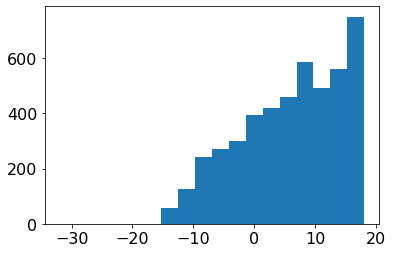

In [281]:
# Create a histogram
hist_results = plt.hist(weather_post_retrofit.temperature,bins)

In [282]:
# Number of hours below 18 C - this is need to put histogram results on same scale as ASHRAE data
number_hours = len(weather_post_retrofit.loc[weather_post_retrofit.temperature < 18.1])

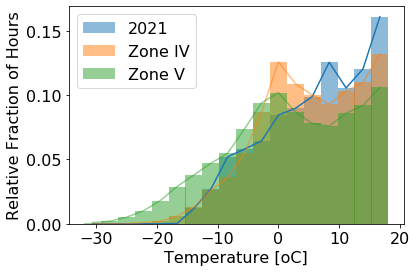

In [283]:
# Visualize

# Create x values for histogram
ASHRAE_temps = ASHRAE_Regions.C.to_list()
ASHRAE_temps.reverse()

# Plot all data
plt.bar(ASHRAE_temps,hist_results[0]/number_hours,alpha = 0.5,width=2.8, label = "2021")
plt.bar(ASHRAE_Regions.C,ASHRAE_Regions.IV,alpha=0.5,width=2.8, label = "Zone IV")
plt.bar(ASHRAE_Regions.C,ASHRAE_Regions.V,alpha=0.5,width=2.8, label = "Zone V")
plt.plot(ASHRAE_temps,hist_results[0]/number_hours)
plt.plot(ASHRAE_Regions.C,ASHRAE_Regions.IV,alpha=0.5)
plt.plot(ASHRAE_Regions.C,ASHRAE_Regions.V,alpha=0.5)

plt.xlabel('Temperature [oC]')
plt.ylabel('Relative Fraction of Hours')

plt.legend()

It's clear we should be expect COP to be nearer to Zone IV for 2021. So the estimated COP of 3.1 to 3.2 is near the expected value of 3.2 for Region IV.


## 6 Utility Rates and Emission Factors

The marginal cost of natural gas was estimated using the Ontatio Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in January 2021 for an Enbridge service area, one for 100 m3 consumption and one for 200 m3. These are shown below. 

![GasCalc.png](GasCalc.png)

The difference in cost between the two bills is 41.7 dollars - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.417 dollars per m3. At the end of 2020 the federal government announced a new cabron pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15 dollars per tonne annually to reach 170 dollars by 2030. It will close to double the current rate by 2030. This has significant implications for hybrid systems and it is considered at the end of this analysis.

In [284]:
# Define gas rate
gas_rate = 0.417 # $/m3

### 5.2 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Two bills were calculated one for a 500 kWh and one for 600 kWh. The bills assumed a TOU breakdown of 60% off-peak, 20% mid-peakm and 20% on-peak. This breakdown considers that the daily TOU breakdown includes 12 hours off-peak (50%), 6 hours mid-peak (25%) and 6 hours on-peak (25%), and also that it is typically colder during the night. This weights electricity consumption further towards the off-peak TOU. 

The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in January 2021.

The results are shown below. For an increase in 100 kWh of electricity consumption, it cost an additional 1.26 dollars.  Marginal peak electricity cost estimate of 0.126 dollars per kWh.
![Elec_Calc.png](ElecCalc.png)

In [285]:
# Define gas rate
elec_rate = 0.126 # $/kWh

The emission factors for electricity and natural gas are include both marginal and annual emission factors from the TAF report "A Clearer View on Ontario's Emissions" 2021 Edition. Fugitive emissions have been ignored.

In [286]:
# Define emission factor assumptions
AEF_elec_2021 = 0.031 # From TAF 2021 report "A Clearer View on Ontario's Emissions"
MEF_elec_2021 = 0.113
AEF_elec_2036 = 0.094 # From TAF 2021 report "A Clearer View on Ontario's Emissions"
MEF_elec_2036 = 0.340
EF_gas = 1.89 # in units kg CO2e per m3 from NIR report

## 7 Current Utility Cost and Carbon Reductions

In [287]:
# Increased electricity cost
elec_cost_increase = elec_increase*elec_rate
elec_cost_increase

390.09651560273153

In [288]:
# Decrease in natural gas costs
gas_cost_reduction = gas_savings_corr*gas_rate
gas_cost_reduction

415.9983543311968

In [289]:
# Net utility cost savings
net_cost_reduction = gas_cost_reduction - elec_cost_increase
net_cost_reduction

25.901838728465293

Visualize change in bills at current rates.

(0, 1000)

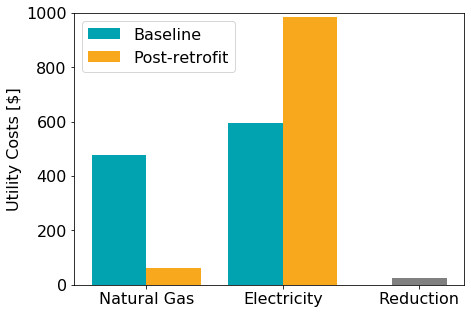

In [290]:
# Create lists for plot
baseline = [post_gas_base_total_corr*gas_rate,post_elec_baseline*elec_rate]
postretrofit = [post_gas_total*gas_rate,post_elec_total*elec_rate]
reduction = [net_cost_reduction]

# Plot 
fig, ax = plt.subplots(figsize = (7,5))
ax.bar([1,2], baseline, width = -0.4, align = 'edge', color = step_blue, label = 'Baseline')
ax.bar([1,2], postretrofit, width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
ax.bar([3],reduction, color = 'grey', width = 0.4)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Natural Gas','Electricity', 'Reduction'])
ax.set_ylabel('Utility Costs [$]')
ax.legend()
ax.set_ylim(0,1000)

In [291]:
# Carbon savings 2021 annual emission factor
carbon_reduction_AEF_2021 = (gas_savings_corr * EF_gas) - (elec_increase*AEF_elec_2021)
carbon_reduction_AEF_2021

1789.4840402579782

In [292]:
# Percentage reduction 2021 AEF
100*(1-((elec_increase*AEF_elec_2021)/(gas_savings_corr * EF_gas)))

94.90967093716876

In [293]:
# Carbon savings 2036 annual emission factor
carbon_reduction_AEF_2036 = (gas_savings_corr * EF_gas) - (elec_increase*AEF_elec_2036)
carbon_reduction_AEF_2036

1594.4357824566125

In [294]:
# Percentage reduction 2036 AEF
100*(1-((elec_increase*AEF_elec_2036)/(gas_savings_corr * EF_gas)))

84.56480864818911

In [295]:
# Carbon reduction 2021 marginal emission factor
carbon_reduction_MEF_2021 = (gas_savings_corr * EF_gas) - (elec_increase*MEF_elec_2021)
carbon_reduction_MEF_2021

1535.6117047069943

In [296]:
# Percentage reduction 2021 MEF
100*(1-((elec_increase*MEF_elec_2021)/(gas_savings_corr * EF_gas)))

81.4449295451635

In [297]:
# Carbon reduction 2036 marginal emission factor
carbon_reduction_MEF_2036 = (gas_savings_corr * EF_gas) - (elec_increase*MEF_elec_2036)
carbon_reduction_MEF_2036

832.8187758036604

In [298]:
# Percentage reduction 2036 MEF
100*(1-((elec_increase*MEF_elec_2036)/(gas_savings_corr * EF_gas)))

44.17058447217337

## 8 Future Cost Reductions Due to Carbon Pricing

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This is outlined in the dataframe below. Note the schedule is not available beyond 2030 but it has been assumed to continue escalating at the same rate. Also note the calculated rate gnores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [299]:
# Import carbon charge data
# You can see this aligns with carbon charge data from enbridge
# https://www.enbridgegas.com/residential/my-account/rates/federal-carbon-charge (below)
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(16)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3)
0,2022,50,0.097875
1,2023,65,0.127238
2,2024,80,0.156600
3,2025,95,0.185963
4,2026,110,0.215325
5,2027,125,0.244688
6,2028,140,0.274050
7,2029,155,0.303412
8,2030,170,0.332775
9,2031,185,0.362230


![Enbridge_CC2.png](Enbridge_CC2.png)

In [300]:
# Add cost escalation due to carbon charge
gas_rate_no_carbon_charge = gas_rate - 0.0979
nat_gas_rate_df['Gas_Rate'] = [gas_rate_no_carbon_charge + x for x in nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)']]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate
0,2022,50,0.097875,0.416975
1,2023,65,0.127238,0.446337
2,2024,80,0.156600,0.475700
3,2025,95,0.185963,0.505062
4,2026,110,0.215325,0.534425
5,2027,125,0.244688,0.563787
6,2028,140,0.274050,0.593150
7,2029,155,0.303412,0.622513
8,2030,170,0.332775,0.651875
9,2031,185,0.362230,0.681330


In [301]:
# Add electricity cost escalation - 
# Assume 2% per year there has been no recent long-term energy plan to for a better estimate
# Just add it to natural gas data frame
nat_gas_rate_df['Elec_Rate'] = [elec_rate*(1.02)**x for x in nat_gas_rate_df.index]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate
0,2022,50,0.097875,0.416975,0.126000
1,2023,65,0.127238,0.446337,0.128520
2,2024,80,0.156600,0.475700,0.131090
3,2025,95,0.185963,0.505062,0.133712
4,2026,110,0.215325,0.534425,0.136386
5,2027,125,0.244688,0.563787,0.139114
6,2028,140,0.274050,0.593150,0.141896
7,2029,155,0.303412,0.622513,0.144734
8,2030,170,0.332775,0.651875,0.147629
9,2031,185,0.362230,0.681330,0.150582


In [302]:
# Add utility costs
nat_gas_rate_df['Annual_Gas_Savings_m3'] = [gas_savings_corr for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase_kWh'] = [elec_increase for x in nat_gas_rate_df.Elec_Rate] #elec_increase + add_elec_increase
nat_gas_rate_df['Annual_Gas_Savings_dol'] = [gas_savings_corr*x for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase_dol'] = [elec_increase*x for x in nat_gas_rate_df.Elec_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol,nat_gas_rate_df.Annual_Elec_Increase_dol)]
nat_gas_rate_df.head(15)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate,Annual_Gas_Savings_m3,Annual_Elec_Increase_kWh,Annual_Gas_Savings_dol,Annual_Elec_Increase_dol,Annual_Net_Cost_Change
0,2022,50,0.097875,0.416975,0.126000,997.597972,3096.004092,415.973414,390.096516,-25.876899
1,2023,65,0.127238,0.446337,0.128520,997.597972,3096.004092,445.265385,397.898446,-47.366939
2,2024,80,0.156600,0.475700,0.131090,997.597972,3096.004092,474.557355,405.856415,-68.700940
3,2025,95,0.185963,0.505062,0.133712,997.597972,3096.004092,503.849326,413.973543,-89.875783
4,2026,110,0.215325,0.534425,0.136386,997.597972,3096.004092,533.141296,422.253014,-110.888282
5,2027,125,0.244688,0.563787,0.139114,997.597972,3096.004092,562.433267,430.698074,-131.735192
6,2028,140,0.274050,0.593150,0.141896,997.597972,3096.004092,591.725237,439.312036,-152.413201
7,2029,155,0.303412,0.622513,0.144734,997.597972,3096.004092,621.017208,448.098276,-172.918931
8,2030,170,0.332775,0.651875,0.147629,997.597972,3096.004092,650.309178,457.060242,-193.248936
9,2031,185,0.362230,0.681330,0.150582,997.597972,3096.004092,679.693426,466.201447,-213.491979


In [303]:
# Total net cost to 2030
nat_gas_rate_df.Annual_Net_Cost_Change.sum()

-2569.8223280997436

In [304]:
nat_gas_rate_df.to_csv('gas_rates_df.csv')

Text(0, 0.5, 'Net Annual Utility Cost Change [$]')

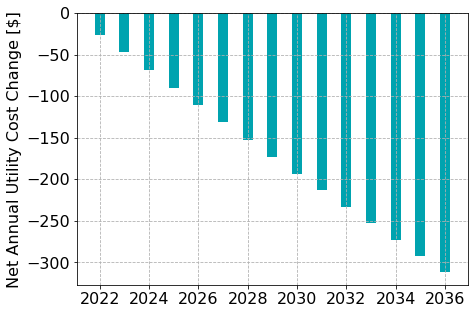

In [305]:
# Visualize -lifetime
plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.Year,nat_gas_rate_df.Annual_Net_Cost_Change,color=step_blue, align = 'center', width = 0.4)
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')

Text(0, 0.5, 'Net Annual Utility Cost Change [$]')

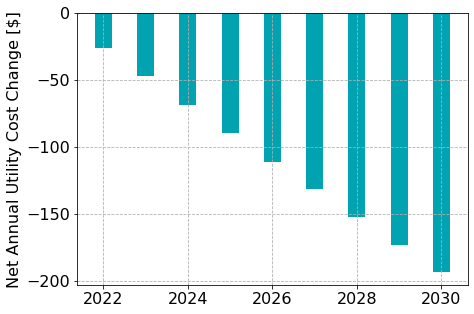

In [306]:
# Visualize - to 2030
plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.loc[nat_gas_rate_df.index<9].Year,
        nat_gas_rate_df.loc[nat_gas_rate_df.index<9].Annual_Net_Cost_Change,
        color=step_blue, 
        align = 'center', 
        width = 0.4)
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')

This analysis is taking the energy savings from the post-retrofit period and assuming that it will be constant on an annual basis moving forward. This is a simplification. In reality, future savings will vary with the annual changes in weather. It is useful to confirm whether or not the post-retrofit was an outlying year that is not a good representation of future savings. To do that it's possible just to look at total HDDs of the post-retrofit period vs. the same time period from 10 previous years. 

In [307]:
HDD_total(datetime.datetime.strptime("2020-12-30","%Y-%m-%d"),datetime.datetime.strptime("2021-10-28","%Y-%m-%d"))['HDDs']

1467.2041666666667

In [308]:
year = [2021,2020,2019,2018,2017,2016,2015,2014,2013,2012]
strts = ["2020-12-30","2019-12-30","2018-12-30","2017-12-30","2016-12-30","2015-12-30","2014-12-30","2013-12-30","2012-12-30","2011-12-30"]
ends = ["2021-10-28","2020-10-28","2019-10-28","2018-10-28","2017-10-28","2016-10-28","2015-10-28","2014-10-28","2013-10-28","2012-10-28"]
HDD_list = []

for st,en, yr in zip(strts,ends, year):
    HDDs_ = HDD_total(datetime.datetime.strptime(st,"%Y-%m-%d"),datetime.datetime.strptime(en,"%Y-%m-%d"))['HDDs']
    HDD_list.append(HDDs_)
    print(str(yr) + " " + str(HDDs_))

2021 1467.2041666666667
2020 1486.1458333333333
2019 1746.9958333333334
2018 1733.1
2017 1388.4541666666664
2016 1526.6375
2015 1996.475
2014 2007.208333333333
2013 1602.4499999999998
2012 1254.7291666666665


In [309]:
# Mean HDDs
sum(HDD_list)/len(HDD_list)

1620.94

In [310]:
# Difference between 2021 and Mean
1467/1620

0.9055555555555556

The total HDDs for the post-retrofit period in this analysis are 9% lower than the mean HDDs for the same period across the last 10 years. It follows that, while 2021 is not a outlier (2 years were warmer - 2012 & 2017 - two year was near in HDDs - 2020 & 2016), it was milder than average. 

This doesn't necessarily mean that the savings would be lower in a year that was closer to the mean. Savings could actually be greater since there are more heating hours. It all depends on the distribution of temperatures and not just the total HDDs. A further complication is that the weather conditions from past 10 years may not necessarily be entirely representative of the next 15 years, due to climate change. 

An additional complication is that we don't actually know the efficiency the homeowners furnace was previously performing at and it was at the end of it's useful life. A new high-efficiency furnace might perform better. As is, the analysis shows the savings from replacing an old high-efficiency furnace, not a new one. Detailed monitoring could help shed light here but funding was not available to do this.

Taking all these factors into account increases complexity of the analysis without providing substantial additional value.
A simpler approach might to consider a sensitivity analysis to look at what happens if gas savings is lower than determined her but electricity consumption remains the same.

In [311]:
# Add utility costs 

# Scenario where gas savings is lower by 2%
nat_gas_rate_df['Annual_Gas_Savings_dol_2perc'] = [gas_savings_corr*x*0.98 for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change_2perc'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol_2perc,nat_gas_rate_df.Annual_Elec_Increase_dol)]

# Scenario where gas savings is lower by 5%
nat_gas_rate_df['Annual_Gas_Savings_dol_5perc'] = [gas_savings_corr*x*0.95 for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change_5perc'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol_5perc,nat_gas_rate_df.Annual_Elec_Increase_dol)]

# Scenario where gas savings is lower by 10%
nat_gas_rate_df['Annual_Gas_Savings_dol_10perc'] = [gas_savings_corr*x*0.90 for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change_10perc'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol_10perc,nat_gas_rate_df.Annual_Elec_Increase_dol)]

In [312]:
# Look at total lifetime cost savings if gas savings is 2% lower than calculated above
nat_gas_rate_df['Annual_Net_Cost_Change_2perc'].sum()

-2383.503847900199

In [313]:
# Look at total lifetime cost savings if gas savings is 5% lower than calculated above
nat_gas_rate_df['Annual_Net_Cost_Change_5perc'].sum()

-2104.0261276008823

In [314]:
# Look at total lifetime cost savings if gas savings is 10% lower than calculated above
nat_gas_rate_df['Annual_Net_Cost_Change_10perc'].sum()

-1638.2299271020213

Cost savings reduces if gas savings are lower. But it doesn't change the broader picture that the ASHP becomes the lower cost option on utility bills. If gas savings were 10% lower, it would just not happen until 2023, instead of 2022.

In [315]:
nat_gas_rate_df.head(15)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate,Annual_Gas_Savings_m3,Annual_Elec_Increase_kWh,Annual_Gas_Savings_dol,Annual_Elec_Increase_dol,Annual_Net_Cost_Change,Annual_Gas_Savings_dol_2perc,Annual_Net_Cost_Change_2perc,Annual_Gas_Savings_dol_5perc,Annual_Net_Cost_Change_5perc,Annual_Gas_Savings_dol_10perc,Annual_Net_Cost_Change_10perc
0,2022,50,0.097875,0.416975,0.126000,997.597972,3096.004092,415.973414,390.096516,-25.876899,407.653946,-17.557430,395.174744,-5.078228,374.376073,15.720443
1,2023,65,0.127238,0.446337,0.128520,997.597972,3096.004092,445.265385,397.898446,-47.366939,436.360077,-38.461631,423.002116,-25.103670,400.738846,-2.840400
2,2024,80,0.156600,0.475700,0.131090,997.597972,3096.004092,474.557355,405.856415,-68.700940,465.066208,-59.209793,450.829488,-44.973073,427.101620,-21.245205
3,2025,95,0.185963,0.505062,0.133712,997.597972,3096.004092,503.849326,413.973543,-89.875783,493.772339,-79.798796,478.656859,-64.683316,453.464393,-39.490850
4,2026,110,0.215325,0.534425,0.136386,997.597972,3096.004092,533.141296,422.253014,-110.888282,522.478470,-100.225456,506.484231,-84.231217,479.827167,-57.574153
5,2027,125,0.244688,0.563787,0.139114,997.597972,3096.004092,562.433267,430.698074,-131.735192,551.184601,-120.486527,534.311603,-103.613529,506.189940,-75.491866
6,2028,140,0.274050,0.593150,0.141896,997.597972,3096.004092,591.725237,439.312036,-152.413201,579.890732,-140.578697,562.138975,-122.826939,532.552713,-93.240678
7,2029,155,0.303412,0.622513,0.144734,997.597972,3096.004092,621.017208,448.098276,-172.918931,608.596863,-160.498587,589.966347,-141.868071,558.915487,-110.817210
8,2030,170,0.332775,0.651875,0.147629,997.597972,3096.004092,650.309178,457.060242,-193.248936,637.302994,-180.242752,617.793719,-160.733477,585.278260,-128.218018
9,2031,185,0.362230,0.681330,0.150582,997.597972,3096.004092,679.693426,466.201447,-213.491979,666.099558,-199.898111,645.708755,-179.507308,611.724084,-145.522637


# 9 NPV Calculation for Electrification

## 9.1 NPV For Each Line Item

In [316]:
# First look at annual change in costs due to assumption of electric resistance water heating
water_heating_kWh = 14.4 * 12 * 10.6  # Assumed tankless water heater and electric tank have comparable EF - 0.96
                                      # 10.6 kWh / m3 of gas & 12 months per year
                                      # 14.4 m3/month of remaining gas consumption    
    
water_heating_w_gas = nat_gas_rate_df['Gas_Rate']*14.4*12 # Yearly gas water heating costs including carbon pricing
water_heating_w_elec = nat_gas_rate_df['Elec_Rate']*water_heating_kWh # Yearly electric resistance water heating costs assuming 2% escalation

water_heating_inc = -1*(water_heating_w_elec - water_heating_w_gas) # Water heating cost increase; negative means increase for NPV
water_heating_inc

0    -158.738400
1    -158.280394
2    -157.914704
3    -157.643177
4    -157.467697
5    -157.390183
6    -157.412597
7    -157.536935
8    -157.765237
9    -158.083598
10   -158.524810
11   -159.076350
12   -159.740422
13   -160.519280
14   -161.415216
dtype: float64

In [317]:
# Function to discount future cashflows
def NPV(year,discount,cashflow):
    npv = cashflow / ((1 + discount) ** year)
    return npv   

# Function to calculate payments if financing conventional equipment
def pay_calc(r,PV,n): # Determines annual payment if financing conventional equipment
                      # r is interest; PV is present value; n is number of years
    payments = (r * PV)/(1-(1+r)**(-n))
    return payments

# Initiatilize some data to iterate over
drs = [0.02,0.05,0.07]
years = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
years_5yr = [1,2,3,4,5] # For furnace calc

# Costs (water heater utility costs defined above)
upfront_cost_ASHP = -1*((19000+3500)*1.13-5000) # $19k ASHP cost; $3.5k service upgrade; + tax; minus $5k incentive
ann_ASHP_loan_repayment = upfront_cost_ASHP/15 # assumes financing at 0%; costs simply spread out over 15 years
new_electric_stove = -1000 # assumed electric stove cost of $1k
new_electric_water_heater = -1*(600+1000)*1.13 # assumed water heater cost of $600 + $1k install + tax

# Savings
ann_prop_insur_sav = 80 # assumed $80/yr property tax savings (obtained from other retrofits)
ann_GCC = 300 # assumed gas customer charge remains unchanged at $300 per year
utility_sav = nat_gas_rate_df['Annual_Net_Cost_Change']*-1 # utility savings as calculated above
stove_replacement = 1000 # in 8-years; assumed gas stove costs comparable to electric
on_demand_WH = 3500*1.13-400 # in 8-years; assumed on-demand WH installed cost of $3.5k + tax minus $400 Enbridge incentive
furnace_AC_cost = 8000*1.13 # assumed average upfront costs of conventional furnace-A/C $8k + tax
annual_furnace_payment = pay_calc(0.04,furnace_AC_cost,5) # Financing furnace; 4% interest over 5 years

NPV_list = []
NPV_list_only_heating = []

for dr in drs:
    NPV_ASHP = 0
    NPV_prop_sav = 0
    NPV_GCC = 0
    NPV_util = 0
    NPV_furnace = 0
    NPV_WH = 0
    for yr,save,inc in zip(years,utility_sav,water_heating_inc):
        NPV_ASHP = NPV_ASHP + NPV(yr,dr,ann_ASHP_loan_repayment)
        NPV_prop_sav = NPV_prop_sav + NPV(yr,dr,ann_prop_insur_sav)
        NPV_GCC = NPV_GCC + NPV(yr,dr,ann_GCC)
        NPV_util = NPV_util + NPV(yr,dr,save)
        NPV_WH = NPV_WH + NPV(yr,dr,inc)
    NPV_stove_replace = NPV(8,dr,stove_replacement)
    NPV_WH_replace = NPV(8,dr,on_demand_WH)
    NPV_elec_stove = new_electric_stove
    NPV_elec_WH = new_electric_water_heater
    for yr in years_5yr:
        NPV_furnace = NPV_furnace + NPV(yr,dr,annual_furnace_payment)
    NPV_list.append([NPV_ASHP,
                     NPV_elec_WH,
                     NPV_elec_stove,
                     NPV_WH, 
                     NPV_furnace, 
                     NPV_WH_replace, 
                     NPV_stove_replace,
                     NPV_util,
                     NPV_prop_sav,
                     NPV_GCC])
    NPV_list_only_heating.append([NPV_ASHP,
                     NPV_furnace, 
                     NPV_util,
                     NPV_prop_sav])

NPV_df = pd.DataFrame({
    'dr02':NPV_list[0],
    'dr05':NPV_list[1],
    'dr07':NPV_list[2]
})

NPV_df_only_heating = pd.DataFrame({
    'dr02':NPV_list_only_heating[0],
    'dr05':NPV_list_only_heating[1],
    'dr07':NPV_list_only_heating[2]
})

In [318]:
NPV_df.index = ["NPV_ASHP",
                     "NPV_Elec_WH",
                     "NPV_Elec_Stove",
                     "NPV_WH_Util_Increase", 
                     "NPV_Furnace_Replace", 
                     "NPV_Gas_WH_Replace", 
                     "NPV_Stove_Replace",
                     "NPV_Utility_Savings",
                     "NPV_Prop_Insur_Savings",
                     "NPV_GCC"]
NPV_df

,dr02,dr05,dr07
NPV_ASHP,-17496.413800,-14133.634362,-12401.942904
NPV_Elec_WH,-1808.000000,-1808.000000,-1808.000000
NPV_Elec_Stove,-1000.000000,-1000.000000,-1000.000000
NPV_WH_Util_Increase,-2035.771998,-1643.617644,-1441.801495
NPV_Furnace_Replace,9571.288068,8791.561341,8325.980254
NPV_Gas_WH_Replace,3034.158270,2406.163932,2069.042367
NPV_Stove_Replace,853.490371,676.839362,582.009105
NPV_Utility_Savings,2104.494903,1586.732024,1329.069604
NPV_Prop_Insur_Savings,1027.941080,830.372643,728.633120
NPV_GCC,3854.779050,3113.897411,2732.374202


In [319]:
NPV_df_only_heating.index = ["NPV_ASHP",
                     "NPV_Furnace_Replace", 
                     "NPV_Utility_Savings",
                     "NPV_Prop_Insur_Savings"]
NPV_df_only_heating

,dr02,dr05,dr07
NPV_ASHP,-17496.413800,-14133.634362,-12401.942904
NPV_Furnace_Replace,9571.288068,8791.561341,8325.980254
NPV_Utility_Savings,2104.494903,1586.732024,1329.069604
NPV_Prop_Insur_Savings,1027.941080,830.372643,728.633120


In [320]:
dr02_NPV_full = NPV_df["dr02"].sum()
dr02_NPV_full

-1894.0340565015035

In [321]:
dr02_NPV_only_heat = NPV_df_only_heating["dr02"].sum()
dr02_NPV_only_heat

-4792.689749557114

In [322]:
dr05_NPV_full = NPV_df["dr05"].sum()
dr05_NPV_full

-1179.6852923812476

In [323]:
dr05_NPV_only_heat = NPV_df_only_heating["dr05"].sum()
dr05_NPV_only_heat

-2924.968354144876

In [324]:
dr07_NPV_full = NPV_df["dr07"].sum()
dr07_NPV_full

-884.6357476852195

In [325]:
dr07_NPV_only_heat = NPV_df_only_heating["dr07"].sum()
dr07_NPV_only_heat

-2018.2599259585

## 9.2 Putting NPV into Equivalent Monthly Payments

In [326]:
# Function to put NPV into equivalent monthly payments over 15 years
# It will keep assume different annual payments incrementally and then calculate NPV
# Once the calculated NPV is greater than the target result it stops and provides equivalent monthly payment
# It overshoots the target value but that's ok because in the report it is rounding to the nearest dollar anyway

def equiv_payments(target, dr):
    result = 0 
    payment = 0
    years = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    while result < target: 
        NPV_ = 0
        payment = payment + 1 # increments payments - this ANNUAL payment
        for yr in years: 
            NPV_ = NPV_ + NPV(yr,dr,payment) # calc NPV
        result = NPV_
    print(NPV_)
    return payment/12 # Put it into monthly     
    
    

In [327]:
# Discount rate 2% full elec
equiv_payments(-1*dr02_NPV_full,0.02) 

1901.6909980849584


12.333333333333334

In [328]:
# Discount rate 2% only heat
equiv_payments(-1*dr02_NPV_only_heat,0.02) 

4792.7752857141195


31.083333333333332

In [329]:
# Discount rate 5% full elec
equiv_payments(-1*dr05_NPV_full,0.05) 

1183.2810163525874


9.5

In [330]:
# Discount rate 5% only heat
equiv_payments(-1*dr05_NPV_only_heat,0.05) 

2927.063566766926


23.5

In [331]:
# Discount rate 7% full elec
equiv_payments(-1*dr07_NPV_full,0.07) 

892.5755725006961


8.166666666666666

In [332]:
# Discount rate 7% only heat
equiv_payments(-1*dr07_NPV_only_heat,0.07) 

2021.9569091342296


18.5